In [1]:
from __future__ import print_function
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import os
from dataset import DatasetFromPandas
import models.dcgan as dcgan
import models.mlp as mlp

import pandas as pd
from sklearn import metrics
from sklearn.metrics import confusion_matrix


parser = argparse.ArgumentParser()
parser.add_argument('--pos_data', default='/storage03/user_data/liuchen01/creds/train_neg.dat', help='path to dataset')
parser.add_argument('--neg_data', default='/storage03/user_data/liuchen01/creds/train_pos.dat', help='path to dataset')
parser.add_argument('--test_data', default='/storage03/user_data/liuchen01/creds/test_feature.dat', help='path to dataset')
parser.add_argument('--test_label', default='/storage03/user_data/liuchen01/creds/test_labels.dat', help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=128, help='input batch size')
parser.add_argument('--nSize', type=int, default=148, help='noise size')
parser.add_argument('--nz', type=int, default=148, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--lrD', type=float, default=0.00005, help='learning rate for Critic, default=0.00005')
parser.add_argument('--lrG', type=float, default=0.00005, help='learning rate for Generator, default=0.00005')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda'  , action='store_true',default=True, help='enables cuda')
parser.add_argument('--ngpu'  , type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--netP', default='samples/netD_epoch_24.pth', help="path to netP (to continue training)")
parser.add_argument('--clamp_lower', type=float, default=-0.01)
parser.add_argument('--clamp_upper', type=float, default=0.01)
parser.add_argument('--Diters', type=int, default=5, help='number of D iters per each G iter')
parser.add_argument('--noBN', action='store_true', help='use batchnorm or not (only for DCGAN)')
parser.add_argument('--mlp_G', action='store_true',default=True, help='use MLP for G')
parser.add_argument('--mlp_D', action='store_true', default=True,help='use MLP for D')
parser.add_argument('--n_extra_layers', type=int, default=0, help='Number of extra layers on gen and disc')
parser.add_argument('--experiment', default=None, help='Where to store samples and models')
parser.add_argument('--adam', action='store_true', help='Whether to use adam (default is rmsprop)')
opt, unknown = parser.parse_known_args()
print(opt)


if opt.experiment is None:
    opt.experiment = 'samples'
os.system('mkdir {0}'.format(opt.experiment))

opt.manualSeed = random.randint(1, 10000) # fix seed
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

Namespace(Diters=5, adam=False, batchSize=128, beta1=0.5, clamp_lower=-0.01, clamp_upper=0.01, cuda=True, experiment=None, lrD=5e-05, lrG=5e-05, mlp_D=True, mlp_G=True, nSize=148, n_extra_layers=0, ndf=64, neg_data='/storage03/user_data/liuchen01/creds/train_pos.dat', netD='', netG='', netP='samples/netD_epoch_24.pth', ngf=64, ngpu=1, niter=25, noBN=False, nz=148, pos_data='/storage03/user_data/liuchen01/creds/train_neg.dat', test_data='/storage03/user_data/liuchen01/creds/test_feature.dat', test_label='/storage03/user_data/liuchen01/creds/test_labels.dat', workers=2)
Random Seed:  1224


In [2]:
pos_data = DatasetFromPandas(opt.pos_data)

neg_data = DatasetFromPandas(opt.neg_data)

dataloader = torch.utils.data.DataLoader(pos_data, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))
neg_dataloader = torch.utils.data.DataLoader(neg_data, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))
test = DatasetFromPandas(opt.test_data)
labels = list(pd.read_csv(opt.test_label,header=None)[0])
testdataloader = torch.utils.data.DataLoader(test, batch_size=len(test),
                                         shuffle=False, num_workers=int(opt.workers))
testdataiter = iter(testdataloader)
testv = Variable(testdataiter.next()).cuda()


In [3]:
traindataloader = torch.utils.data.DataLoader(pos_data, batch_size=len(pos_data),
                                         shuffle=True, num_workers=int(opt.workers))
traindataiter = iter(traindataloader)

trainv = Variable(traindataiter.next()).cuda()


In [62]:


ngpu = int(opt.ngpu)
nSize = int(opt.nz)

nz = int(opt.nz)
nSize = int (opt.nSize)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
n_extra_layers = int(opt.n_extra_layers)
netG = nn.Sequential(
    # Z goes into a linear of size: ngf
    nn.Linear(nz, ngf),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(ngf, ngf),
    nn.Dropout(0.3),
    nn.ReLU(),
#     nn.Linear(ngf, ngf),
#     nn.Dropout(0.3)
#     nn.ReLU(True),
    nn.Linear(ngf, nSize),
    nn.Sigmoid()
)
netD = nn.Sequential(
    nn.Linear(nSize, ndf),
    nn.Dropout(0.3),
    nn.ReLU(True),
    nn.Linear(ndf, ndf),
    nn.Dropout(0.3),
    nn.ReLU(True),
#     nn.Linear(ndf, ndf),
#     nn.ReLU(True),
    nn.Linear(ndf, 1),
#     nn.Softmax()
)
print (netG)
print (netD)
input = torch.FloatTensor(opt.batchSize, opt.nSize)
noise = torch.FloatTensor(opt.batchSize, nz)
# fixed_noise = torch.FloatTensor(opt.batchSize, nz, 1, 1).normal_(0, 1)
if opt.cuda:
    netD.cuda()
    netG.cuda()
    input = input.cuda()
    noise = noise.cuda()

# setup optimizer
if opt.adam:
    optimizerD = optim.Adam(netD.parameters(), lr=opt.lrD, betas=(opt.beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lrG, betas=(opt.beta1, 0.999))
else:
    optimizerD = optim.RMSprop(netD.parameters(), lr = opt.lrD)
    optimizerG = optim.RMSprop(netG.parameters(), lr = opt.lrG)

Sequential (
  (0): Linear (148 -> 64)
  (1): Dropout (p = 0.3)
  (2): ReLU ()
  (3): Linear (64 -> 64)
  (4): Dropout (p = 0.3)
  (5): ReLU ()
  (6): Linear (64 -> 148)
  (7): Sigmoid ()
)
Sequential (
  (0): Linear (148 -> 64)
  (1): Dropout (p = 0.3)
  (2): ReLU (inplace)
  (3): Linear (64 -> 64)
  (4): Dropout (p = 0.3)
  (5): ReLU (inplace)
  (6): Linear (64 -> 1)
)


In [63]:
input = torch.FloatTensor(opt.batchSize, opt.nSize)


if opt.cuda:
    netD.cuda()
    netG.cuda()
    input = input.cuda()
    # noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

# setup optimizer
if opt.adam:
    optimizerD = optim.Adam(netD.parameters(), lr=opt.lrD, betas=(opt.beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lrG, betas=(opt.beta1, 0.999))
else:
    optimizerD = optim.RMSprop(netD.parameters(), lr = opt.lrD)
    optimizerG = optim.RMSprop(netG.parameters(), lr = opt.lrG)
test = DatasetFromPandas(opt.test_data)
labels = list(pd.read_csv(opt.test_label,header=None)[0])
def reset_grad():
    netG.zero_grad()
    netD.zero_grad()


In [64]:
for epoch in range(10):
    data_iter = iter(dataloader)
    neg_iter = iter(neg_dataloader)
    d_step = 5
    i = 0
    while i< len(dataloader):
        j = 0
        while j<d_step and i < len(dataloader):
            ############################
            # (1) Update D network
            ###########################
            j += 1
            i += 1
            data = data_iter.next()

            # sample data with real and fake
            real_cpu = data

            if opt.cuda:
                real_cpu = real_cpu.cuda()
            input.resize_as_(real_cpu).copy_(real_cpu)
            inputv = Variable(input)
            try:
                noise = neg_iter.next()
    #                 print (noise.size())
            except:
                neg_iter = iter(neg_dataloader)
                noise = neg_iter.next()
            if opt.cuda:
                noise = noise.cuda()
            # noise.resize_(opt.batchSize, nz, 1, 1).normal_(0, 1)
            noisev = Variable(noise, volatile = True) # totally freeze netG
            fake = Variable(netG(noisev).data)

            # Discriminator
            D_real = netD(inputv)
            D_fake = netD(fake)
            errD = 0.5 * (torch.mean((D_real - 1)**2) + torch.mean(D_fake**2))
            errD.backward()
            optimizerD.step()
            reset_grad()

            ############################
            # (2) Update G network
            ###########################
        try:
                noise = neg_iter.next()

        except:
                neg_iter = iter(neg_dataloader)
                noise = neg_iter.next()
        if opt.cuda:
            noise = noise.cuda()
        noisev = Variable(noise)
        fake = netG(noisev)
        G_fake = netD(fake)
        errG = 0.5 * torch.mean((G_fake - 1)**2)
        errG.backward()
        optimizerG.step()
        reset_grad()
    print (D_real.cpu().data[:10],D_fake.cpu().data[:10])

    print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f '
            % (epoch, opt.niter, i, len(dataloader),
            errD.data[0], errG.data[0]))
#         pred_probs = (D_real.cpu().data.numpy())
#         print (max(pred_probs),min(pred_probs))
#         pred_probs = (G_fake.cpu().data.numpy())
#         print (max(pred_probs),min(pred_probs))

#         pred_probs = (netD(testv).cpu().data.numpy())
#         print (max(pred_probs),min(pred_probs),len(pred_probs))
#         pred_probs = (netD(netG(testv)).cpu().data.numpy())
#         print (max(pred_probs),min(pred_probs),len(pred_probs))
    if epoch%5==0:
        torch.save(netD.state_dict(), '{0}/lsgan_netD_epoch_{1}.pth'.format(opt.experiment, epoch))
#         pred_probs = (netD(testv.cuda()).cpu().data.numpy())
#         pred_probs = (pred_probs-min(pred_probs))/(max(pred_probs)-min(pred_probs))
#         for i in range(0,10,2):
#             pred = [1 if j>i/10.0 else 0 for j in pred_probs ]
#             print (confusion_matrix(labels,pred))
#             print ("Accuracy, ",  metrics.accuracy_score(labels,pred))

Variable containing:
 0.9350
 0.8219
 0.9100
 0.9322
 0.9694
 0.8248
 0.8943
 0.7847
 0.7091
 1.0516
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]
 Variable containing:
1.00000e-02 *
 -0.3154
  1.0954
  1.0354
  3.8210
  3.6852
  0.5093
  1.3435
  0.2414
  1.3880
 -2.5157
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]

[0/25][1662/1662] Loss_D: 0.015447 Loss_G: 0.497408 
Variable containing:
 0.8328
 1.0118
 0.8787
 1.1296
 0.8383
 0.9026
 0.9553
 0.8542
 1.0634
 1.0885
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]
 Variable containing:
1.00000e-02 *
 -1.0305
 -3.3722
  0.0367
  1.5655
  2.7129
  2.2456
  1.2637
  0.8703
  1.2387
 -1.1638
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]

[1/25][1662/1662] Loss_D: 0.010157 Loss_G: 0.490268 
Variable containing:
 1.1486
 1.1159
 1.1619
 0.9182
 1.0819
 0.7002
 0.7507
 1.1327
 0.7615
 1.1194
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]
 Variable containing:
 0.0904
 0.1213
-0.0261
 0.1201
 0.0035
-0.0036
-0.0138
 0.3166
-0.0772
 0.1057
[torc

Process Process-90:
KeyboardInterrupt
Traceback (most recent call last):
Process Process-88:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process Process-87:


KeyboardInterrupt: 

Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    samples = collate_fn([dataset[i] for i in batch_indices])
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "dataset.py", line 11, in __getitem__
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
  File "/usr/local/lib/python2.7/dist-packages/torc

In [65]:
D_real.cpu().data[:10].numpy()

array([[ 0.89009535],
       [ 1.0625751 ],
       [ 1.13957906],
       [ 0.96736288],
       [ 0.86975586],
       [ 0.90423822],
       [ 0.88350105],
       [ 1.06635475],
       [ 1.05911839],
       [ 0.93840349]], dtype=float32)

In [66]:
D_fake.cpu().data[:10].numpy()

array([[ 0.17108215],
       [-0.04602516],
       [-0.24130186],
       [ 0.12629423],
       [ 0.03500208],
       [ 0.00803518],
       [ 0.08853036],
       [ 0.13303322],
       [-0.24929819],
       [-0.20617774]], dtype=float32)

In [67]:
pred_probs = (netD((testv)).cpu().data.numpy())

In [68]:
tr_pred_probs = (netD((trainv)).cpu().data.numpy())

In [69]:
import numpy as np
np.sum(pred_probs[:,0])

175326.33

In [71]:
max(pred_probs),min(pred_probs)

(array([ 1.55457652], dtype=float32), array([-0.46520892], dtype=float32))

In [39]:
pred_probs=[p[1] for p  in pred_probs ]

In [43]:
pred=[1 if p[0]>p[1] else 0 for p in pred_probs ]

In [44]:
# pred_probs = (pred_probs-min(pred_probs))/(max(pred_probs)-min(pred_probs))
print (confusion_matrix(labels,pred))
print ("Accuracy, ",  metrics.accuracy_score(labels,pred))

[[     0  53158]
 [     0 152450]]
Accuracy,  0.741459476285


In [54]:
# pred_probs = (pred_probs-min(pred_probs))/(max(pred_probs)-min(pred_probs))
for i in range(0,10,1):
    pred = [0 if j>i/10.0 else 1 for j in pred_probs ]
    print (confusion_matrix(labels,pred))
    print ("Accuracy, ",  metrics.accuracy_score(labels,pred))

[[ 53158      0]
 [152450      0]]
Accuracy,  0.258540523715
[[  4617  48541]
 [ 18695 133755]]
Accuracy,  0.672989377845
[[  4512  48646]
 [ 18117 134333]]
Accuracy,  0.675289871989
[[  4460  48698]
 [ 17740 134710]]
Accuracy,  0.676870549784
[[  4410  48748]
 [ 17439 135011]]
Accuracy,  0.678091319404
[[  4354  48804]
 [ 17160 135290]]
Accuracy,  0.679175907552
[[  4310  48848]
 [ 16894 135556]]
Accuracy,  0.680255632077
[[  4259  48899]
 [ 16610 135840]]
Accuracy,  0.681388856465
[[  4191  48967]
 [ 16255 136195]]
Accuracy,  0.682784716548
[[  4088  49070]
 [ 15721 136729]]
Accuracy,  0.684880938485


In [28]:
pd.Series([0 if j > 0.8 else 1 for j in pred_probs ]).value_counts()

1    163331
0     42277
dtype: int64

In [27]:
pd.Series(labels).value_counts()

1    152450
0     53158
dtype: int64

In [47]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


([array([      0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,  205608.]),
  array([ 205608.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

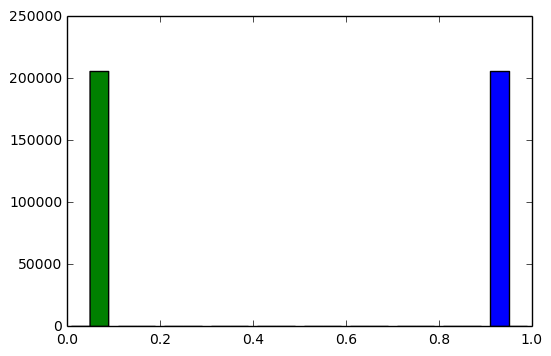

In [48]:
matplotlib.use('Agg')
plt.hist(pred_probs,bins=[i/10.0for i in range(0,11,1)])

In [4]:
testdataloader = torch.utils.data.DataLoader(test, batch_size=len(test),
                                         shuffle=False, num_workers=int(opt.workers))


In [5]:
testdataiter = iter(testdataloader)

In [6]:
testv = Variable(testdataiter.next())

In [7]:
testv.data.size()

torch.Size([205608, 148])

In [11]:
netP = mlp.MLP_P(opt.nSize,  ndf, ngpu)
netP.load_state_dict(torch.load('{0}/netD_epoch_{1}.pth'.format(opt.experiment, 0)))

In [38]:
pred_probs = (netP(netG(testv)).data.numpy())


In [41]:
max(pred_probs),min(pred_probs)

(array([ 1.], dtype=float32), array([ 0.], dtype=float32))

In [40]:
    pred_probs = (pred_probs-min(pred_probs))/(max(pred_probs)-min(pred_probs))


In [42]:
for i in range(0,10,1):
    pred = [1 if j>i/10.0 else 0 for j in pred_probs ]
    print (confusion_matrix(labels,pred))
    print ("Accuracy, ",  metrics.accuracy_score(labels,pred))


[[     0  53158]
 [     1 152449]]
Accuracy,  0.741454612661
[[    10  53148]
 [    29 152421]]
Accuracy,  0.741367067429
[[   193  52965]
 [   598 151852]]
Accuracy,  0.739489708572
[[  1693  51465]
 [  4824 147626]]
Accuracy,  0.726231469593
[[  7591  45567]
 [ 19759 132691]]
Accuracy,  0.682278899654
[[20295 32863]
 [52989 99461]]
Accuracy,  0.582448153768
[[ 37613  15545]
 [101433  51017]]
Accuracy,  0.431062993658
[[ 49490   3668]
 [138630  13820]]
Accuracy,  0.307916034396
[[ 52770    388]
 [150805   1645]]
Accuracy,  0.264654099062
[[ 53144     14]
 [152369     81]]
Accuracy,  0.258866386522


In [37]:
for i in range(0,10,1):
    pred = [0 if j>i/10.0 else 1 for j in pred_probs ]
    print (confusion_matrix(labels,pred))
    print ("Accuracy, ",  metrics.accuracy_score(labels,pred))


[[ 53158      0]
 [152449      1]]
Accuracy,  0.258545387339
[[ 33422  19736]
 [105121  47329]]
Accuracy,  0.392742500292
[[20374 32784]
 [66066 86384]]
Accuracy,  0.519230769231
[[  9657  43501]
 [ 33499 118951]]
Accuracy,  0.62550095327
[[  3441  49717]
 [ 13522 138928]]
Accuracy,  0.692429282907
[[   945  52213]
 [  4450 148000]]
Accuracy,  0.724412474223
[[   201  52957]
 [  1237 151213]]
Accuracy,  0.736420761838
[[    42  53116]
 [   271 152179]]
Accuracy,  0.740345706393
[[     8  53150]
 [    49 152401]]
Accuracy,  0.741260067702
[[     1  53157]
 [     5 152445]]
Accuracy,  0.741440021789


In [3]:
9/5

1